In [1]:
!pip install tensorflow==2.9.1

Defaulting to user installation because normal site-packages is not writeable


In [4]:
#import libraries
import os
import cv2
import random
import shutil
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tqdm.auto import tqdm
import csv
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import layers, models, optimizers
from keras.models import Sequential, Model
from sklearn import metrics
from keras.applications.resnet import ResNet50
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Input, Lambda, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten

In [2]:
#load dataset
dataset_path= 'C:/Users/Madhavi S Rao/Downloads/dataset/training_set'

In [3]:
#thwe number of images for each of the two classes(normal vs cancer)
# then the total number of images in the whole datatset
all_path = dataset_path + "/all"
hem_path = dataset_path + "/hem"

all_train_imgs = os.listdir(all_path)
normal_train_imgs = os.listdir(hem_path)

print("Number of cancer cell images: " + str(len(all_train_imgs)))
print("Number of normal cell images: " + str(len(normal_train_imgs)))

Number of cancer cell images: 7272
Number of normal cell images: 3389


In [5]:
entries = all_train_imgs + normal_train_imgs
num_entries = len(entries)
print("Total number of images: " + str(num_entries))

Total number of images: 10661


The following function split the dataset into training, validation and test sets, using the splitting percentages passed as arguments.

In [6]:
#the following function split the dataset into training, validation and test sets, using splitting percentages as arguments

def split_dataset(dataset, dataset_size, train_percentage=0.7, val_percentage=0.15, test_percentage=0.15, shuffle=True):
  """
    split_dataset splits the dataset into training, validation and test sets.

    :param dataset: a list representing the whole dataset
    :param dataset_size: number of elements in the dataset
    :param train_percentage: the percentage of the dataset that will be used for training
    :param val_percentage: the percentage of the dataset that will be used for validation
    :param test_percentage: the percentage of the dataset that will be used for testing
    :param shuffle: if True the elements of the dataset will be randomly shuffled
    :return: three lists representing the training, validation and test sets
  """
  if train_percentage + val_percentage + test_percentage != 1:
    print('Total of percentages must be 1')
    return None, None, None
  
  if shuffle:
    random.shuffle(dataset)
    
  train_size = int(train_percentage * dataset_size)
  val_size = int(val_percentage * dataset_size)

  train_set = dataset[0:train_size]
  val_set = dataset[train_size:train_size+val_size]
  test_set = dataset[train_size+val_size:dataset_size]
    
  return train_set, val_set, test_set

In [7]:
random.seed(24) # seed is specified to always obtain the same results
training_set, validation_set, test_set = split_dataset(entries, num_entries)

num_training_samples = len(training_set)
num_validation_samples = len(validation_set)
num_test_samples = len(test_set)

print("Number of samples in the training set: " + str(num_training_samples))
print("Number of samples in the validation set: " + str(num_validation_samples))
print("Number of samples in the test set: " + str(num_test_samples))

Number of samples in the training set: 7462
Number of samples in the validation set: 1599
Number of samples in the test set: 1600


Number of cancer cell images: 5139
Number of normal cell images: 2323


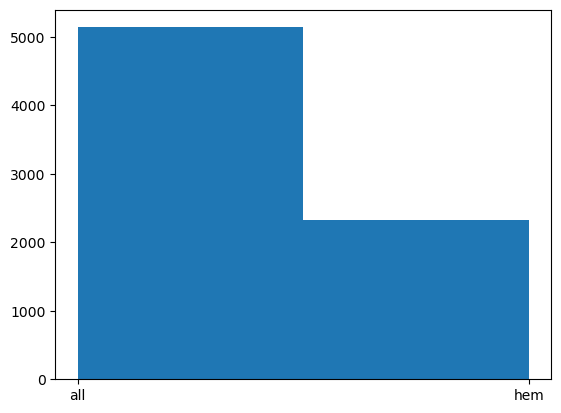

In [8]:
#solving the imbalanced classes 
all_samples = [entry for entry in training_set if entry.split(".")[0][-3:] == 'all']
hem_samples = [entry for entry in training_set if entry.split(".")[0][-3:] == 'hem']

labels = [entry.split(".")[0][-3:] for entry in training_set]
_ = plt.hist(labels, bins=2)

print("Number of cancer cell images: " + str(len(all_samples)))
print("Number of normal cell images: " + str(len(hem_samples)))

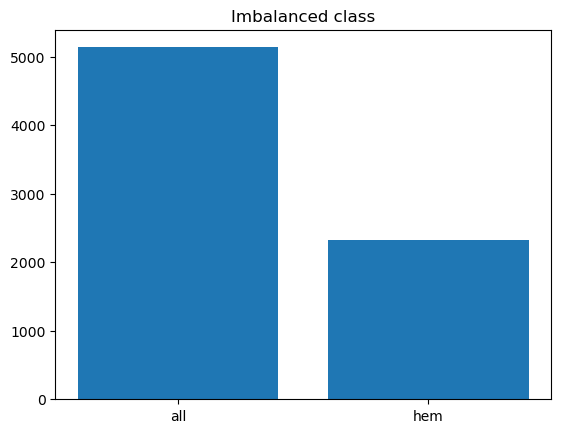

In [9]:
plt.bar(['all', 'hem'], [len(all_samples), len(hem_samples)])
plt.title('Imbalanced class')
plt.show()

In [10]:
#imbalance can cause issues during training if the two classes don't have the same number of images
expected_samples_per_class = num_training_samples//2
print("Number of expected images per class: " + str(expected_samples_per_class))

Number of expected images per class: 3731


In [11]:
#sub-sample the class of cancer cells by selecting the required number of images at random
sampled_all = random.sample(all_samples, expected_samples_per_class)
print("Number of sampled cancer cell images: " + str(len(sampled_all)))

Number of sampled cancer cell images: 3731


In [12]:
#apply data augmentation for the smallest class. 
#Therefore, first chhose a sample of images to apply the augmentation on

hem_samples_needed = expected_samples_per_class - len(hem_samples)
sampled_hem = random.sample(hem_samples, hem_samples_needed)
print("Number of sampled normal cell images to perform augmentation: " + str(len(sampled_hem)))
print("Final number of normal cell images: " + str(len(sampled_hem) + len(hem_samples)))

Number of sampled normal cell images to perform augmentation: 1408
Final number of normal cell images: 3731


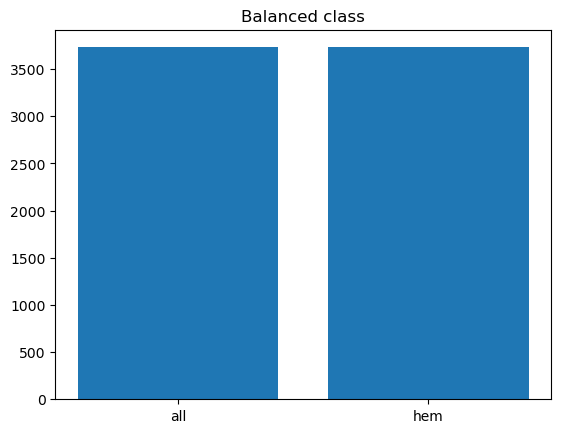

In [13]:
#solving the imbalanced classes 
plt.bar(['all', 'hem'], [len(sampled_all), len(sampled_all)])
plt.title('Balanced class')
plt.show()


Data Augmentation

In [14]:
#the following function randomly flips or rotates the original image to do data augmentation

def random_flip_or_rotation(original_image):
  '''
  random_flip_or_rotation randomly rotates or flips the image
  :param original_image: the image on which to perform the transformation
  :return: the transformed image
  '''
  if random.randint(0,1): # decide whether to flip the image or not
    horizontal = random.randint(0,1)
    if horizontal:
      new_image = tf.image.flip_left_right(original_image)
    else:
      new_image = tf.image.flip_up_down(original_image)
  else: # rotate the image of a random degree (between 90° and 270°)
    k = random.randint(1,3)
    new_image = tf.image.rot90(original_image, k)

  return np.asarray(new_image)

Example of flips and rotations

In [15]:
#examples of flips and rotations
original_image = cv2.imread("C:/Users/Madhavi S Rao/Downloads/dataset/training_set/all/UID_1_1_1_all.bmp")
vertical_flip = tf.image.flip_up_down(original_image)
horizontal_flip = tf.image.flip_left_right(original_image)
rotation_90 = tf.image.rot90(original_image, k=1)
rotation_180 = tf.image.rot90(original_image, k=2)
rotation_270 = tf.image.rot90(original_image, k=3)

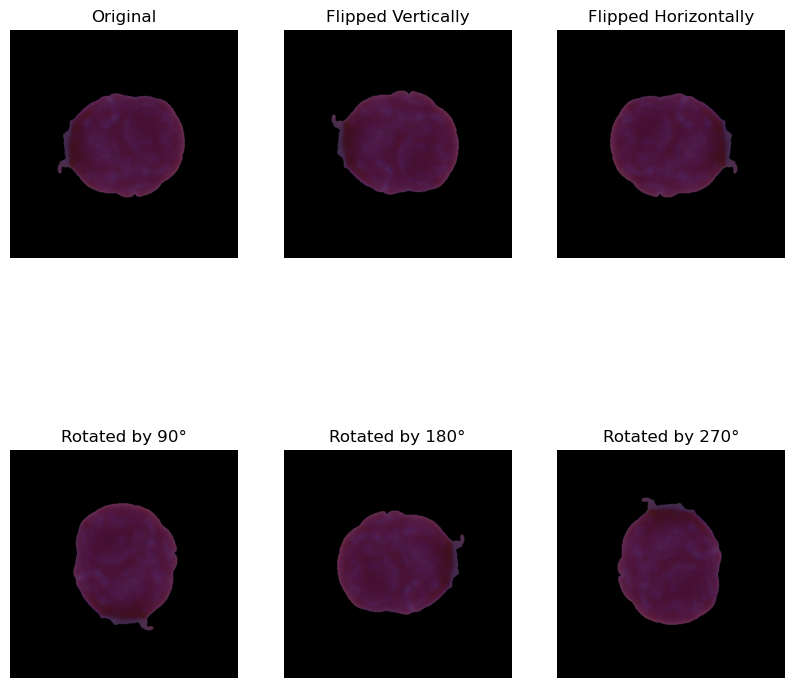

In [16]:
fig = plt.figure(figsize=(10, 10))

fig.add_subplot(2, 3, 1)
plt.imshow(original_image)
plt.axis('off')
plt.title("Original")

fig.add_subplot(2, 3, 2)
plt.imshow(vertical_flip)
plt.axis('off')
plt.title("Flipped Vertically")

fig.add_subplot(2, 3, 3)
plt.imshow(horizontal_flip)
plt.axis('off')
plt.title("Flipped Horizontally")

fig.add_subplot(2, 3, 4)
plt.imshow(rotation_90)
plt.axis('off')
plt.title("Rotated by 90°")

fig.add_subplot(2, 3, 5)
plt.imshow(rotation_180)
plt.axis('off')
plt.title("Rotated by 180°")

fig.add_subplot(2, 3, 6)
plt.imshow(rotation_270)
plt.axis('off')
_ = plt.title("Rotated by 270°")

In [17]:
#Since the images have a lot of background, we need to crop them to get rid of as much of the black outline as we can.
#the function below, which use the tresholding technique and then adds some black padding.

def crop_and_resize_image(image):
  ''' 
  crop_image crops the image with a thresholding technique (If the pixel value is smaller than the threshold, it is set to 0, otherwise it is set to a maximum value)
  :param image: image to crop
  :return: image cropped and resized
  '''
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  # 'tresh' is the image thresholded
  _,thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY) # 1 is the threshold value, 255 is the maximum value
  contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cnt = contours[0] # we have a single object in the image, so we take the first contour
  x,y,w,h = cv2.boundingRect(cnt)
  cropped_image = image[y:y+h, x:x+w]

  # Enlarge the image to get a square shape
  max_dimension = max(cropped_image.shape)
  vertical_gap = max_dimension - cropped_image.shape[0]
  if vertical_gap % 2 == 0: # even
    top = bottom = vertical_gap // 2
  else:
    top = vertical_gap // 2
    bottom = top + 1
  horizontal_gap = max_dimension - cropped_image.shape[1]
  if horizontal_gap % 2 == 0: # even
    left = right = horizontal_gap // 2
  else:
    left = horizontal_gap // 2
    right = left + 1
  return cv2.copyMakeBorder(cropped_image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=0) # value=0 for black

the dataset's very first picture.

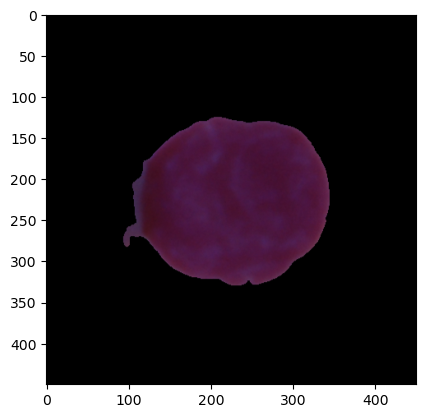

In [18]:
#the dataset's first image
import cv2 as cv
img = cv.imread("C:/Users/Madhavi S Rao/Downloads/dataset/training_set/all/UID_1_1_1_all.bmp")
plt.imshow(img)
plt.show() 
 

(252, 252, 3)

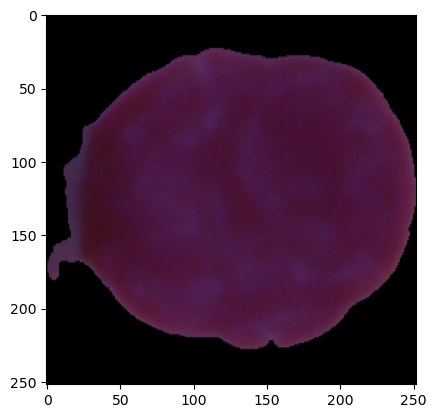

In [19]:
#image after cropping
cropped_image = crop_and_resize_image(img)
plt.imshow(cropped_image)
cropped_image.shape

In [20]:
#Storing the preprocessed dataset 
#apply data augmentation and image cropping to the dataset after dividing it into three sets for storage.

new_dataset_path = "C:/Users/Madhavi S Rao/Downloads/SplittedDataset"
training_path = new_dataset_path + "/training_set"
validation_path = new_dataset_path + "/validation_set"
test_path = new_dataset_path + "/test_set"

In [21]:
# remove the old folder 'SplittedDataset'
shutil.rmtree(new_dataset_path, ignore_errors=True)

# create the structure
os.makedirs(new_dataset_path)
os.makedirs(training_path)
os.makedirs(validation_path)
os.makedirs(test_path)
os.makedirs(training_path + "/all")
os.makedirs(validation_path + "/all")
os.makedirs(test_path + "/all")
os.makedirs(training_path + "/hem")
os.makedirs(validation_path + "/hem")
os.makedirs(test_path + "/hem")

store the training set.

In [22]:
for sample in sampled_all: # store cropped cancer cell images
  img = cv2.imread(dataset_path + '/all/' + sample)
  cropped_image = crop_and_resize_image(img)
  cv2.imwrite(training_path + '/all/' + sample, cropped_image)

for sample in hem_samples: # store cropped normal cell images
  img = cv2.imread(dataset_path +'/hem/' + sample)
  cropped_image = crop_and_resize_image(img)
  cv2.imwrite(training_path + '/hem/' + sample, cropped_image)

for sample in sampled_hem: # store cropped normal cell augmented images
  img = cv2.imread(dataset_path +"/hem/" + sample)
  augmented_img = random_flip_or_rotation(img)
  cropped_image = crop_and_resize_image(augmented_img)
  cv2.imwrite(training_path + '/hem/augmented_' + sample, cropped_image)

validation set

In [24]:
for sample in validation_set: # store cropped validation set images
  label = sample.split(".")[0][-3:]
  img = cv2.imread(dataset_path + '/' + label + '/' + sample)
  cropped_image = crop_and_resize_image(img)
  cv2.imwrite(validation_path + '/' + label +'/' + sample, cropped_image)

test set

In [25]:
for sample in test_set: # store cropped test set images
  label = sample.split(".")[0][-3:]
  img = cv2.imread(dataset_path + '/' + label + '/' + sample)
  cropped_image = crop_and_resize_image(img)
  cv2.imwrite(test_path + '/' + label +'/' + sample, cropped_image)

In [26]:
train_dir = 'C:/Users/Madhavi S Rao/Downloads/SplittedDataset/training_set/'
test_dir = 'C:/Users/Madhavi S Rao/Downloads/SplittedDataset/test_set/'
val_dir = 'C:/Users/Madhavi S Rao/Downloads/SplittedDataset/validation_set/'

In [27]:
LOCAL_MODELS_FOLDER = "C:/Users/Madhavi S Rao/Downloads/models"
if not os.path.exists(LOCAL_MODELS_FOLDER):
  os.makedirs(LOCAL_MODELS_FOLDER)
GLOBAL_MODELS_FOLDER = "C:/Users/Madhavi S Rao/Downloads/models/v"
if not os.path.exists(GLOBAL_MODELS_FOLDER):
  os.makedirs(GLOBAL_MODELS_FOLDER)

BATCH_SIZE = 32
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224


In [28]:
def load_training_set (image_height, image_width, batch_size):
  '''
  load_training_set loads the training set from the "training_set" folder. The images are resized to height x width
  :param image_height: standard height of the images
  :param image_width: standard width of the images
  :param batch_size: size of each batch
  :return the training set
  '''
  return image_dataset_from_directory(
    train_dir,
    image_size = (image_height, image_width),
    batch_size = batch_size,
    class_names = ['hem', 'all']) # explicit ordering of the labels, 0 for hem, 1 for all

In [29]:
def load_validation_set (image_height, image_width, batch_size):
  '''
  load_validation_set loads the validation set from the "validation_set" folder. The images are resized to height x width
  :param image_height: standard height of the images
  :param image_width: standard width of the images
  :param batch_size: size of each batch
  :return the validation set
  '''
  return image_dataset_from_directory(
    val_dir,
    image_size = (image_height, image_width),
    batch_size = batch_size,
    class_names = ['hem', 'all']) 

In [30]:
def load_test_set (image_height, image_width, batch_size):
  '''
  load_test_set loads the test set from the "test_set" folder. The images are resized to height x width
  :param image_height: standard height of the images
  :param image_width: standard width of the images
  :param batch_size: size of each batch
  :return the test set
  '''
  return image_dataset_from_directory(
    test_dir,
    image_size = (image_height, image_width),
    batch_size = batch_size,
    shuffle = False,
    class_names = ['hem', 'all'])

In [31]:
def compile_model (model, optimizer='adam', learning_rate = 0.0001):
  '''
  compile_model is used to compile the current model
  :param model: model to compile
  :param optimizer: optimizer to be used
  :param learning_rate: learning rate parameter for the optimizer
  '''
  if optimizer == 'adam':
    model.compile(loss="binary_crossentropy",
      optimizer=optimizers.Adam(learning_rate=learning_rate),
      metrics=["accuracy"])
  elif optimizer == 'rmsprop':
    model.compile(loss="binary_crossentropy",
                  optimizer = optimizers.RMSprop(learning_rate=learning_rate),
                  metrics=['accuracy'])
  model.summary()

In [32]:
def show_training_and_validation_performance(history):
  '''
  show_training_and_validation_performance is used to plot the performances during the training phase
  :param history: object in which are recorded all the events
  '''
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'bo', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

In [39]:
def run_model (model, model_name, epochs=60 ,patience=5, monitor='val_loss'):
  '''
  run_model is used to run the current mode
  :param model: model to run
  :param model_name: name given to save the model
  :param epochs: how many epochs to do
  :param patience: patience value for Early Stopping
  :param monitor: what to monitor for Early Stopping and Model Checkpoint
  '''
  # local save path for the models
  save_path = LOCAL_MODELS_FOLDER + '/' + model_name + '.h5'
  callbacks_list = [
                  keras.callbacks.EarlyStopping(monitor=monitor, patience=patience),
                  keras.callbacks.ModelCheckpoint(
                      filepath = save_path,
                      monitor=monitor,
                      verbose=1,
                      save_best_only=True)
                  ]
  history = model.fit(train_g,
                    epochs=epochs,
                      verbose=1,
                    validation_data=val_g,
                    callbacks=callbacks_list)
  # save on Drive only the best model
  shutil.copy(save_path, GLOBAL_MODELS_FOLDER + '/' + model_name + '.h5')
  show_training_and_validation_performance(history)

In [5]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import f1_score

def evaluate_model (model):
    y_score = model.predict(test_g)
    y_pred = np.rint(y_score) # to have 0 or 1
    y_true = tf.concat([labels_batch for data_batch, labels_batch in test_g], axis = 0)
    print("Classification report: ")
    print(metrics.classification_report(y_true,y_pred,digits = 4))
    metrics.ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
    #fpr,tpr,th = metrics.roc_curve(y_true,y_score)     # ROC curve
    #roc_auc = metrics.roc_auc_score(y_true,y_score)
    #plt.figure()
    #plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    #plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    #plt.xlim([0.0, 1.0])
    #plt.ylim([0.0, 1.0])
    #plt.xlabel('False Positive Rate')
    #plt.ylabel('True Positive Rate')
    #plt.title('ROC curve')
    #plt.legend(loc="lower right")
    plt.show()

In [35]:
train_g = load_training_set(IMAGE_HEIGHT, IMAGE_WIDTH, BATCH_SIZE)
val_g = load_validation_set(IMAGE_HEIGHT, IMAGE_WIDTH, BATCH_SIZE)
test_g = load_test_set(IMAGE_HEIGHT, IMAGE_WIDTH, BATCH_SIZE)

Found 7462 files belonging to 2 classes.
Found 1599 files belonging to 2 classes.
Found 1600 files belonging to 2 classes.


In [34]:
from tensorflow.keras.applications import VGG16
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(224,224,3)
)

In [35]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [36]:
conv_base.trainable = False

In [37]:
inputs = keras.Input(shape=(224,224,3))
x = keras.applications.vgg16.preprocess_input(inputs)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
vgg_model = keras.Model(inputs, outputs)
compile_model(vgg_model)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                             

Epoch 1/10
234/234 [==============================] - ETA: 0s - loss: 3.7941 - accuracy: 0.6691
Epoch 1: val_loss improved from inf to 5.13350, saving model to C:/Users/Madhavi S Rao/Downloads/models\model_vgg.h5
234/234 [==============================] - 5042s 22s/step - loss: 3.7941 - accuracy: 0.6691 - val_loss: 5.1335 - val_accuracy: 0.5641
Epoch 2/10
234/234 [==============================] - ETA: 0s - loss: 2.3984 - accuracy: 0.7612
Epoch 2: val_loss improved from 5.13350 to 2.29173, saving model to C:/Users/Madhavi S Rao/Downloads/models\model_vgg.h5
234/234 [==============================] - 1221s 5s/step - loss: 2.3984 - accuracy: 0.7612 - val_loss: 2.2917 - val_accuracy: 0.7348
Epoch 3/10
234/234 [==============================] - ETA: 0s - loss: 1.8124 - accuracy: 0.7971
Epoch 3: val_loss improved from 2.29173 to 1.97942, saving model to C:/Users/Madhavi S Rao/Downloads/models\model_vgg.h5
234/234 [==============================] - 1944s 8s/step - loss: 1.8124 - accuracy: 0.

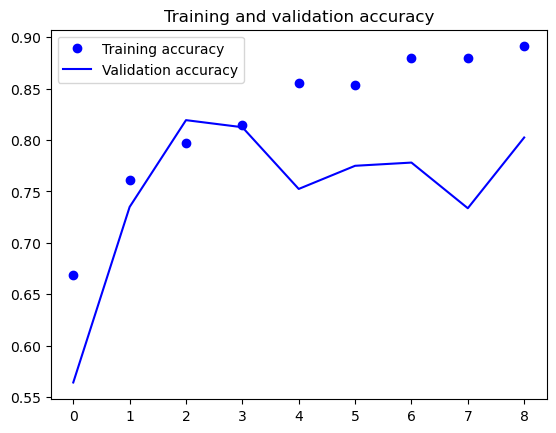

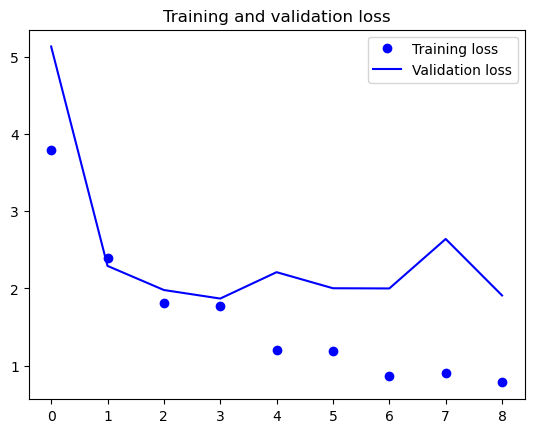

In [43]:
run_model(vgg_model, 'model_vgg', epochs = 10,patience=5, monitor='val_loss')

50/50 [==============================] - 202s 4s/step
Classification report: 
              precision    recall  f1-score   support

           0     0.7023    0.6594    0.6802       508
           1     0.8459    0.8700    0.8578      1092

    accuracy                         0.8031      1600
   macro avg     0.7741    0.7647    0.7690      1600
weighted avg     0.8003    0.8031    0.8014      1600



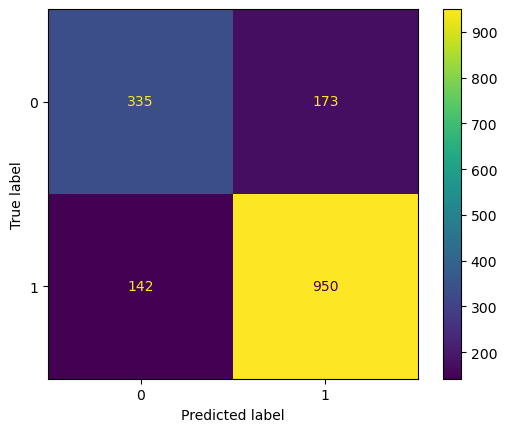

In [44]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER+ '/model_vgg.h5'))

In [45]:
conv_base = keras.applications.ResNet50( 
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False)

In [46]:
conv_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_5[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [47]:
conv_base.trainable = False

In [48]:
inputs = keras.Input(shape=(224, 224, 3))
x = conv_base(inputs, training=False)

# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu') (x)
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(1, activation ='sigmoid')(x)
rmodel = keras.Model(inputs, outputs)
compile_model(rmodel)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 32)                65568     
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                           

Epoch 1/10
234/234 [==============================] - ETA: 0s - loss: 0.5890 - accuracy: 0.6908
Epoch 1: val_loss improved from inf to 0.48869, saving model to C:/Users/Madhavi S Rao/Downloads/models\model_r.h5
234/234 [==============================] - 1717s 7s/step - loss: 0.5890 - accuracy: 0.6908 - val_loss: 0.4887 - val_accuracy: 0.8018
Epoch 2/10
234/234 [==============================] - ETA: 0s - loss: 0.4980 - accuracy: 0.7553
Epoch 2: val_loss improved from 0.48869 to 0.41308, saving model to C:/Users/Madhavi S Rao/Downloads/models\model_r.h5
234/234 [==============================] - 1943s 8s/step - loss: 0.4980 - accuracy: 0.7553 - val_loss: 0.4131 - val_accuracy: 0.8299
Epoch 3/10
234/234 [==============================] - ETA: 0s - loss: 0.4143 - accuracy: 0.8077
Epoch 3: val_loss improved from 0.41308 to 0.32985, saving model to C:/Users/Madhavi S Rao/Downloads/models\model_r.h5
234/234 [==============================] - 2112s 9s/step - loss: 0.4143 - accuracy: 0.8077 - 

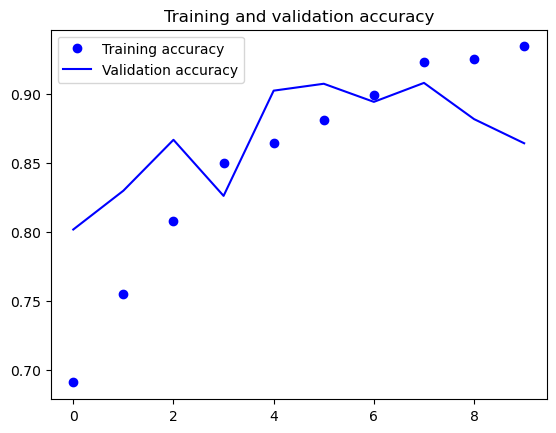

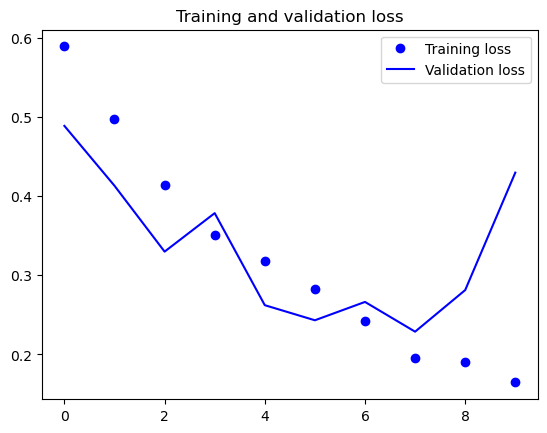

In [49]:
run_model(rmodel, 'model_r', epochs = 10, patience=5, monitor='val_loss')

50/50 [==============================] - 80s 2s/step
Classification report: 
              precision    recall  f1-score   support

           0     0.8456    0.8839    0.8643       508
           1     0.9448    0.9249    0.9348      1092

    accuracy                         0.9119      1600
   macro avg     0.8952    0.9044    0.8995      1600
weighted avg     0.9133    0.9119    0.9124      1600



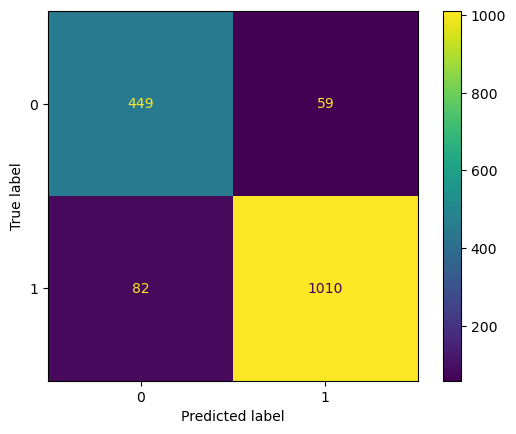

In [51]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER+ '/model_r.h5'))

In [48]:
from tensorflow.keras.applications import VGG19
vgg19_model = VGG19(input_shape=(224,224,3), weights='imagenet',include_top=False)

In [51]:
for layer in vgg19_model.layers:
    layer.trainable = False

In [52]:
inputs = keras.Input(shape=(224,224,3))
x = keras.applications.vgg19.preprocess_input(inputs)
x = vgg19_model(x)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation = 'relu')(x)
predictions = Dense(1, activation = 'sigmoid')(x)
model19 = Model(inputs = inputs, outputs = predictions)
compile_model(model19)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                           

Epoch 1/10
234/234 [==============================] - ETA: 0s - loss: 0.5265 - accuracy: 0.7396
Epoch 1: val_loss improved from inf to 0.61027, saving model to C:/Users/Madhavi S Rao/Downloads/models\vgg19.h5
234/234 [==============================] - 1846s 8s/step - loss: 0.5265 - accuracy: 0.7396 - val_loss: 0.6103 - val_accuracy: 0.6573
Epoch 2/10
234/234 [==============================] - ETA: 0s - loss: 0.4912 - accuracy: 0.7600
Epoch 2: val_loss improved from 0.61027 to 0.47431, saving model to C:/Users/Madhavi S Rao/Downloads/models\vgg19.h5
234/234 [==============================] - 1764s 8s/step - loss: 0.4912 - accuracy: 0.7600 - val_loss: 0.4743 - val_accuracy: 0.7880
Epoch 3/10
234/234 [==============================] - ETA: 0s - loss: 0.4677 - accuracy: 0.7712
Epoch 3: val_loss improved from 0.47431 to 0.43726, saving model to C:/Users/Madhavi S Rao/Downloads/models\vgg19.h5
234/234 [==============================] - 1725s 7s/step - loss: 0.4677 - accuracy: 0.7712 - val_lo

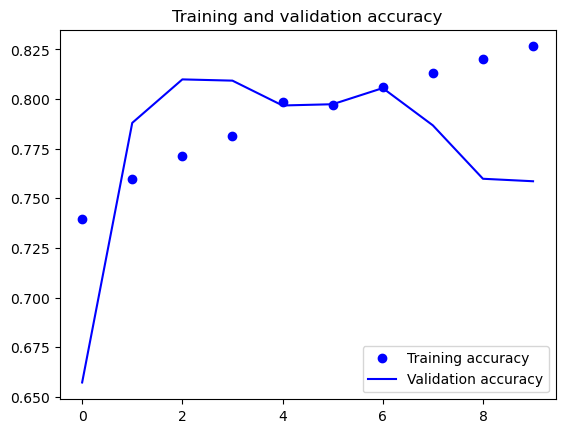

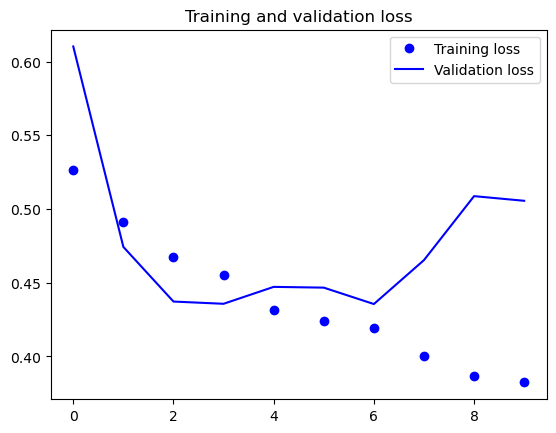

In [54]:
run_model(model19, 'vgg19', epochs = 10, patience=5, monitor='val_loss')

50/50 [==============================] - 282s 6s/step
Classification report: 
              precision    recall  f1-score   support

           0     0.7096    0.7165    0.7130       508
           1     0.8675    0.8636    0.8655      1092

    accuracy                         0.8169      1600
   macro avg     0.7885    0.7900    0.7893      1600
weighted avg     0.8174    0.8169    0.8171      1600



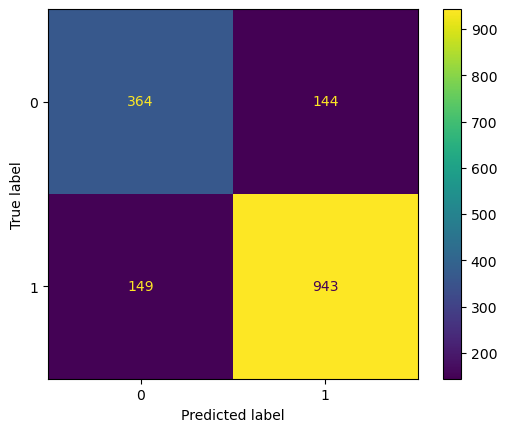

In [55]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER+ '/vgg19.h5'))

In [80]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras import applications

In [81]:
base_model = applications.InceptionV3(weights='imagenet', 
                                include_top=False, 
                                input_shape=(224, 224,3))

In [82]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_16[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

In [83]:
base_model.trainable = False

In [84]:
inputs = keras.Input(shape=(224,224,3))
x = tf.keras.applications.inception_v3.preprocess_input(inputs)
x = base_model(x)
x = keras.layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1024, activation = 'relu')(x)
x = layers.Dense(512, activation = 'relu')(x)
x = layers.Dense(128, activation = 'relu')(x)
inc = layers.Dense(1, activation = 'sigmoid')(x)
model = Model(inputs = inputs, outputs = inc)
compile_model(model)

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d_7   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                           

Epoch 1/20
234/234 [==============================] - ETA: 0s - loss: 0.5974 - accuracy: 0.6836
Epoch 1: val_loss improved from inf to 0.49863, saving model to C:/Users/Madhavi S Rao/Downloads/models\inc.h5
234/234 [==============================] - 691s 3s/step - loss: 0.5974 - accuracy: 0.6836 - val_loss: 0.4986 - val_accuracy: 0.7755
Epoch 2/20
234/234 [==============================] - ETA: 0s - loss: 0.5569 - accuracy: 0.7116
Epoch 2: val_loss improved from 0.49863 to 0.49076, saving model to C:/Users/Madhavi S Rao/Downloads/models\inc.h5
234/234 [==============================] - 644s 3s/step - loss: 0.5569 - accuracy: 0.7116 - val_loss: 0.4908 - val_accuracy: 0.7767
Epoch 3/20
234/234 [==============================] - ETA: 0s - loss: 0.5399 - accuracy: 0.7324
Epoch 3: val_loss did not improve from 0.49076
234/234 [==============================] - 645s 3s/step - loss: 0.5399 - accuracy: 0.7324 - val_loss: 0.4959 - val_accuracy: 0.7774
Epoch 4/20
234/234 [=======================

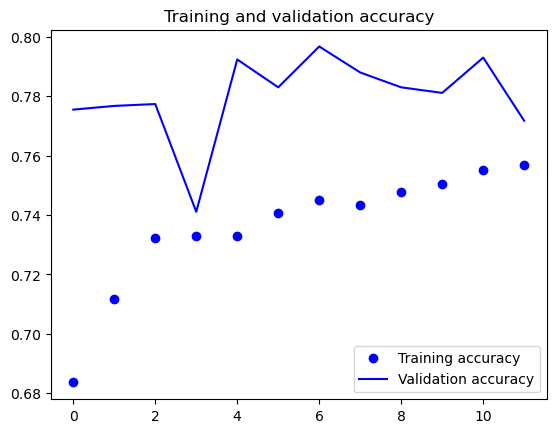

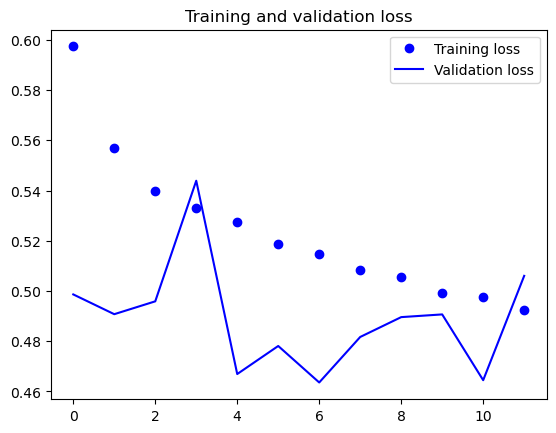

In [85]:
run_model(model, 'inc', epochs = 20, patience=5, monitor='val_loss')

50/50 [==============================] - 132s 3s/step
Classification report: 
              precision    recall  f1-score   support

           0     0.7315    0.6220    0.6723       508
           1     0.8356    0.8938    0.8637      1092

    accuracy                         0.8075      1600
   macro avg     0.7835    0.7579    0.7680      1600
weighted avg     0.8026    0.8075    0.8030      1600



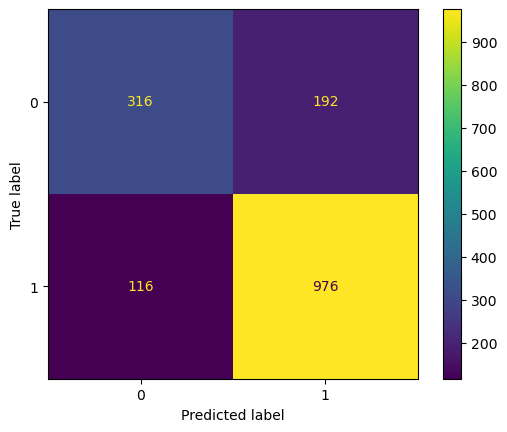

In [86]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER+ '/inc.h5'))

In [37]:
from tensorflow.keras.applications import EfficientNetB0

In [38]:
conv_base = EfficientNetB0(input_shape=(224,224,3), weights='imagenet', include_top=False)
conv_base.trainable = False

In [39]:
conv_base.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 224, 224, 3)  0           ['normalization[0][0

In [40]:
inputs = keras.Input(shape=(224, 224, 3))
x = conv_base(inputs, training=False)

# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(1024, activation='relu') (x)
x = layers.Dropout(0.5)(x)
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(1, activation ='sigmoid')(x)
m = keras.Model(inputs, outputs)
compile_model(m)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                             

Epoch 1/10
234/234 [==============================] - ETA: 0s - loss: 0.5497 - accuracy: 0.7227
Epoch 1: val_loss improved from inf to 0.47453, saving model to C:/Users/Madhavi S Rao/Downloads/models\eff.h5
234/234 [==============================] - 344s 1s/step - loss: 0.5497 - accuracy: 0.7227 - val_loss: 0.4745 - val_accuracy: 0.7836
Epoch 2/10
234/234 [==============================] - ETA: 0s - loss: 0.5055 - accuracy: 0.7556
Epoch 2: val_loss improved from 0.47453 to 0.46539, saving model to C:/Users/Madhavi S Rao/Downloads/models\eff.h5
234/234 [==============================] - 349s 1s/step - loss: 0.5055 - accuracy: 0.7556 - val_loss: 0.4654 - val_accuracy: 0.7774
Epoch 3/10
234/234 [==============================] - ETA: 0s - loss: 0.4824 - accuracy: 0.7706
Epoch 3: val_loss improved from 0.46539 to 0.43158, saving model to C:/Users/Madhavi S Rao/Downloads/models\eff.h5
234/234 [==============================] - 338s 1s/step - loss: 0.4824 - accuracy: 0.7706 - val_loss: 0.431

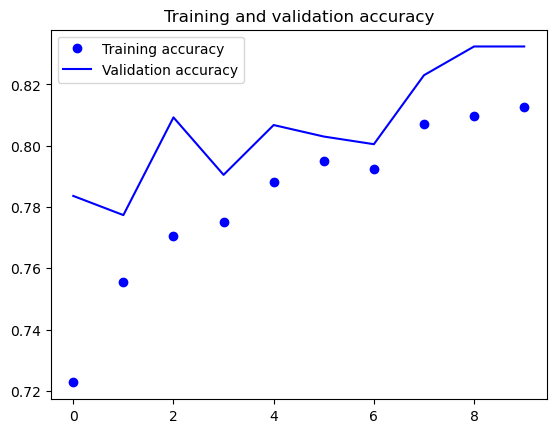

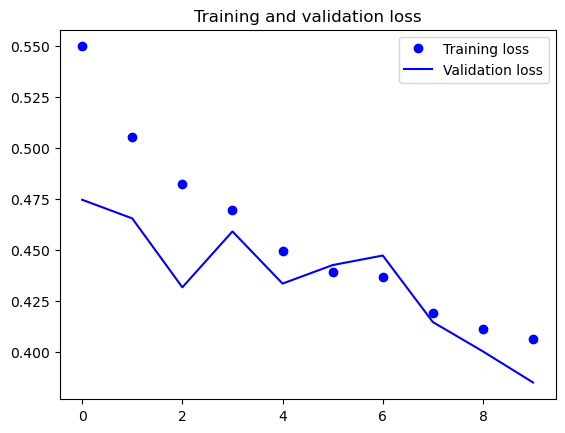

In [41]:
run_model(m, 'eff', epochs=10, patience=5, monitor='val_loss')

50/50 [==============================] - 43s 828ms/step
Classification report: 
              precision    recall  f1-score   support

           0     0.7474    0.7165    0.7317       508
           1     0.8706    0.8874    0.8789      1092

    accuracy                         0.8331      1600
   macro avg     0.8090    0.8019    0.8053      1600
weighted avg     0.8315    0.8331    0.8322      1600



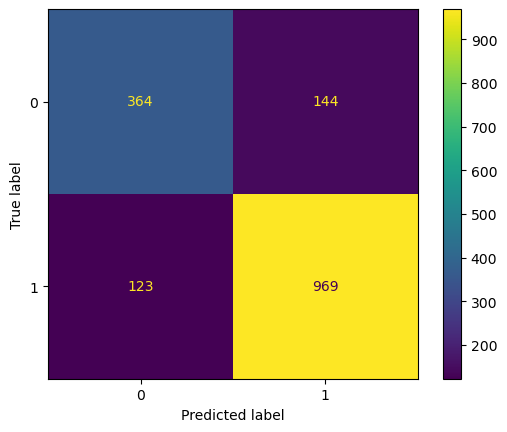

In [42]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER+ '/eff.h5'))